In [71]:
# Load libraries

In [ ]:
import numpy as np 
import pandas as pd 

import os, re, gc, random, tqdm

from nltk.tokenize import TweetTokenizer
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tqdm import tqdm
from wordcloud import WordCloud


import torchtext
from torchtext import vocab, data

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from torchtext import data

In [6]:
vocab.tqdm = tqdm.tqdm_notebook

In [ ]:
# Data Path Definition

In [7]:
path = "/content/drive/MyDrive/DeepLearning/jigsaw-unintended-bias-in-toxicity-classification"
emb_path = "/content/drive/MyDrive/DeepLearning"
n_folds = 3
device = 'cuda'
gc.enable()

In [7]:
# Seed Fix 

In [8]:
# seed
seed = 7777
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [116]:
# Data PrerProcessing'
#1. Leverage Tweet Tokenizer 
#2. Remove special character , http links etc

In [9]:
class RegExCleaner():

    def __init__(self, expressions=[]):
        r"""Create class from compiled expressions: [(re.compile(pattern), repl)]"""
        self.expressions = expressions

    @staticmethod
    def _compile(expressions):
        regexps = []
        for pattern, repl in expressions.items():
            regexps.append((re.compile(pattern), repl))
        return regexps
        
    @classmethod
    def from_dict(cls, custom_dic):
        r"""Create class from dictionary with flexible patterns {pattern : replacing}"""
        return cls(cls._compile(custom_dic))
    
    @classmethod
    def from_vocab(cls, vocab):
        r"""Create class from vocabulary with fixed patterns {pattern : replacing}"""
        pattern = re.compile("|".join(map(re.escape, vocab.keys())))
        repl = lambda match: vocab[match.group(0)]
        return cls([(pattern, repl)])
    
    def __add__(self, b):
        return RegExCleaner(self.expressions + b.expressions)

    def __call__(self, s):
        for regex, repl in self.expressions:
            s = regex.sub(repl, s) 
        return s

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
cleaner = RegExCleaner.from_dict({r'https?:/\/\S+':r' ',
                                  r'[^A-Za-z0-9!.,?$\'\"]+':r' '})
def preparation(s): 
    s = cleaner(s)
    return ' '.join(tknzr.tokenize(s))

In [10]:
# Curated evaluation metric with three types of metrics coming from identity 
# and backgrounds groups are combined and weighted as  0.75 for biases and 0.25 overall

#power mean of these metrices  taken 

class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score
    
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

def as_torch(x):
    return torch.FloatTensor([float(x)])

# Cross Validation Class for Training
class PartialSet():
    def __init__(self, ds, indices):
        self.ds = ds
        self.idx = indices
        self.len = len(indices)
        self.fields = self.ds.fields
        
    def update(self, idx):
        self.idx = idx
        self.len = len(idx)
        
    def __getitem__(self, idx):
        return self.ds[self.idx[idx]]
    
    def __len__(self):
        return self.len

# Classification 
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

#data 
class DataFrameDataset(torchtext.data.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        keys = dict(fields)
        for n, f in list(keys.items()):
            if isinstance(n, tuple):
                keys.update(zip(n, f))
                del keys[n]
        keys = keys.keys()
        examples = []
        for i, row in tqdm.tqdm_notebook(df.iterrows(), total=len(df)):
            examples.append(data.Example.fromlist([row[k] for k in keys], fields))

        super().__init__(examples, fields, **kwargs)

In [28]:
# Actual train data , divide training data in Kfolds

cols = ['id', 'comment_text', 'target'] + identity_columns
dtypes = {'target': np.float16,'comment_text': object,'id': np.int32}
for c in identity_columns:
    dtypes[c] = np.float16
df = pd.read_csv(os.path.join(path, 'train.csv'), usecols=cols, dtype=dtypes, index_col=[0])

y = df.target.values > 0.5

skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)
# Test csv
test_df = pd.read_csv(os.path.join(path, 'test.csv'),
                dtype={'comment_text': object,'id': np.int32}, index_col=[0])

test_df['prediction'] = 0

In [29]:
#transform sentence to sequence of encoded words
def sentence2numbers(s, fill_as=1): # fill <unk> token
    seq = []
    for w in s:
        try:
            seq.append(vocabulary.stoi[w])
        except KeyError:
            seq.append(fill_as)
    return np.array(seq, dtype=np.int32) 

In [30]:
print(df.iloc[28]['comment_text'])
print("Toxicity Level: ",df.iloc[28]['target'])

Thanks! We're really going to try — not only to improve civility, but also to make comments more dynamic and interesting.
Toxicity Level:  0.0


In [32]:
df.head(10)

,target,comment_text,black,christian,female,homosexual_gay_or_lesbian,jewish,male,muslim,psychiatric_or_mental_illness,white
id,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59849,0.000000,Thank you!! This would make my life a lot less...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59852,0.000000,This is such an urgent design problem; kudos t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59855,0.000000,Is this something I'll be able to install on m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59856,0.893555,haha you guys are a bunch of losers.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59859,0.666504,ur a sh*tty comment.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59861,0.457520,hahahahahahahahhha suck it.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59863,0.000000,FFFFUUUUUUUUUUUUUUU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239575,0.000000,The ranchers seem motivated by mostly by greed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Other PreProcessing for removing symbols, contractions, punctuation

In [109]:
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

In [111]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()


isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}


def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [112]:
contraction_mapping = {
    "Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }

In [ ]:
#short words to long words

In [33]:
import re

def decontracted(phrase):

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [34]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# Other Non English symbols

In [115]:
puncts = {"‘": "'", "´": "'", "°": "", "€": "e", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '…': ' '}

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ') 
    return text

In [35]:
preprocessed_comments = []
for sentence in tqdm(df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() )
    preprocessed_comments.append(sent.lower().strip())

100%|██████████| 1804874/1804874 [01:16<00:00, 23594.21it/s]


In [36]:
df['comment_text'] = preprocessed_comments

In [37]:
preprocessed_comments_test = []
for sentence in tqdm(test_df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split())
    preprocessed_comments_test.append(sent.lower().strip())

100%|██████████| 97320/97320 [00:03<00:00, 25418.93it/s]


In [38]:
test_df['comment_text'] = preprocessed_comments_test

In [49]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(df2.loc[~df2[feature].isnull(),feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

In [88]:
df2 = pd.read_csv(os.path.join(path, 'train.csv'))

In [89]:
preprocessed_comments = []
for sentence in tqdm(df2['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() )
    preprocessed_comments.append(sent.lower().strip())

100%|██████████| 1804874/1804874 [01:10<00:00, 25499.93it/s]


In [90]:
df2['comment_text'] = preprocessed_comments

In [91]:
train_len = len(df2.index)
miss_val_train_df = df2.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

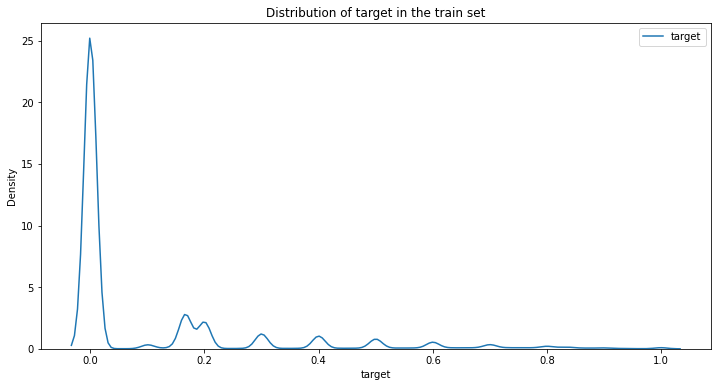

In [92]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(df2['target'],kde=True,hist=False, bins=120, label='target')
plt.legend()
plt.show()

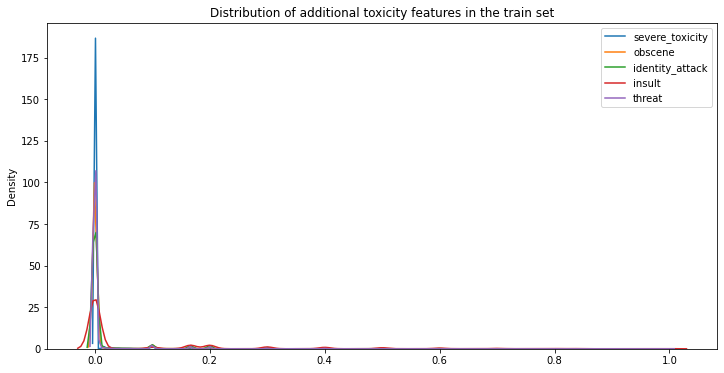

In [93]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

In [94]:
def make_wordcloud(comment_words,title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
              min_font_size = 10,random_state=101,repeat=True).generate(str(comment_words)) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

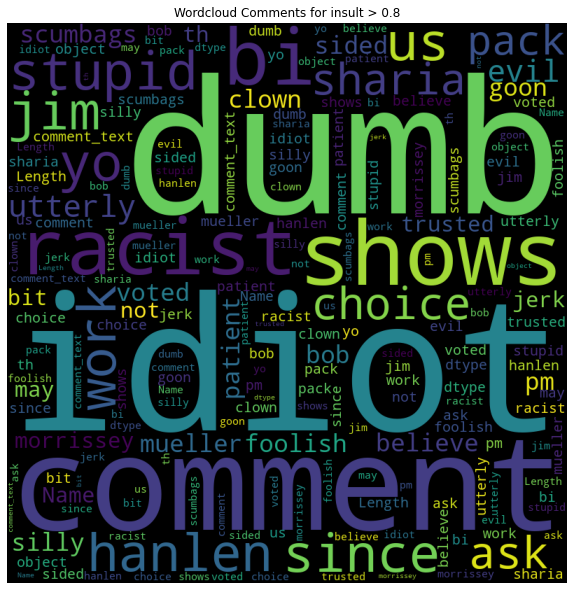

In [95]:
make_wordcloud(df2.loc[df2['insult'] > 0.8]['comment_text'].sample(10000),title='Wordcloud Comments for insult > 0.8')


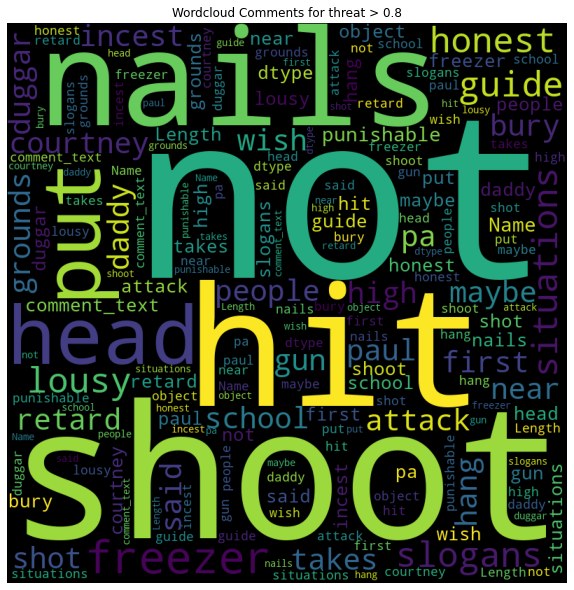

In [96]:
make_wordcloud(df2.loc[df2['threat'] > 0.8]['comment_text'],title='Wordcloud Comments for threat > 0.8')

In [97]:
df2=df2[0:10000]

In [98]:
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

for column in identity_columns + ['target']:
    df2[column] = np.where(df2[column] >= 0.5, True, False)

In [99]:

y = df2['target'].values

In [100]:
train_df, cv_df, y_train, y_cv = train_test_split(df2, y, test_size=0.2, random_state=42)


In [101]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [102]:
train_tfidf = vectorizer.fit_transform(train_df["comment_text"])
cv_tfidf = vectorizer.transform(cv_df["comment_text"])
test_tfidf = vectorizer.transform(test_df["comment_text"])

In [103]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def threshold_based_prediction(proba,threshold,tpr,fpr):
    thres = threshold[np.argmax(fpr*(1-tpr))]
    predictions = []
    for i in proba:
        if i>=thres:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [104]:
alpha = [10 ** x for x in range(-5, 2)]
auc_array_train=[]
auc_array_cv=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=5,class_weight='balanced')
  clf.fit(train_tfidf, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(train_tfidf, y_train)
    
    
  predict_y_train = sig_clf.predict_proba(train_tfidf)[:,1]
  predict_y = sig_clf.predict_proba(cv_tfidf)[:,1]
  auc_array_train.append(roc_auc_score(y_train, predict_y_train))
  auc_array_cv.append(roc_auc_score(y_cv, predict_y))
  print('For values of alpha = ', i, "The auc score on CV is:",roc_auc_score(y_cv, predict_y))

For values of alpha =  1e-05 The auc score on CV is: 0.810816
For values of alpha =  0.0001 The auc score on CV is: 0.8254805333333333
For values of alpha =  0.001 The auc score on CV is: 0.8034773333333332
For values of alpha =  0.01 The auc score on CV is: 0.7876821333333334
For values of alpha =  0.1 The auc score on CV is: 0.7841066666666666
For values of alpha =  1 The auc score on CV is: 0.7866538666666668
For values of alpha =  10 The auc score on CV is: 0.7896832


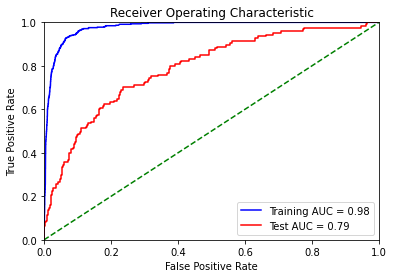

In [108]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_cv, predict_y)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


plt.title('Receiver Operating Characteristic')

plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

	TRAIN DATA CONFUSION MATRIX


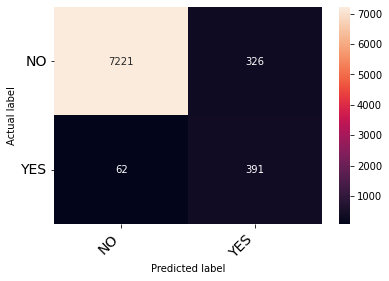

In [105]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_cv, predict_y)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


predtrain = sig_clf.predict_proba(train_tfidf)[:,1]
predcv = sig_clf.predict_proba(cv_tfidf)[:,1]
pred = sig_clf.predict_proba(test_tfidf)[:,1]

predtrain = threshold_based_prediction(predtrain,threshold_train,tpr_train,fpr_train)
cm = confusion_matrix(y_train, predtrain)
print("\tTRAIN DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

In [106]:
predcv = threshold_based_prediction(predcv,threshold_test,tpr_test,fpr_test)
print(classification_report(y_cv,predcv))

              precision    recall  f1-score   support

       False       0.98      0.63      0.77      1875
        True       0.12      0.76      0.21       125

    accuracy                           0.64      2000
   macro avg       0.55      0.70      0.49      2000
weighted avg       0.92      0.64      0.73      2000



In [117]:
# Conclusion
# With Logistic regression we are seeing that the model is slightly overfitting on the train data
# It is not doing very good against the unintended bias that we are trying to avoid
# A lot of comments that are usually not toxic has been classified as toxic by our model by looking at the confusion matrix
# From the f1 sore as well, we can make out the same info

In [ ]:

pad_token = 0 

txt_field = data.Field(sequential=True, preprocessing=sentence2numbers,
                       pad_token=pad_token, use_vocab=False)
num_field = data.Field(sequential=False, dtype=torch.float,  use_vocab=False)
idx_field = data.Field(sequential=False, dtype=torch.int64,  use_vocab=False)

train_fields = [
    ('id', idx_field), 
    ('target', num_field), 
    ('comment_text', txt_field),
]
test_fields = [
    ('id', idx_field), 
    ('comment_text', txt_field), 
]

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm_pandas
tqdm_pandas.pandas()

df.comment_text = df.comment_text.progress_apply(preparation)
test_df.comment_text = test_df.comment_text.progress_apply(preparation)

counter = Counter()
for comment in df.comment_text:
    counter.update(comment.split())

  0%|          | 0/1804874 [00:00<?, ?it/s]

  0%|          | 0/97320 [00:00<?, ?it/s]

In [ ]:
# create vocabulary from glove cache
vec = vocab.Vectors(os.path.join(emb_path, 'glove.840B.300d.txt'), cache=emb_path)
vocabulary = vocab.Vocab(counter, max_size=500000, vectors=vec, specials=['<pad>', '<unk>'])
torch.zero_(vocabulary.vectors[1]); 

del vec
gc.collect();
print('Embedding vocab size: ', vocabulary.vectors.size(0))

Embedding vocab size:  404791


In [ ]:
# create datasets
ds = DataFrameDataset(df.reset_index(), train_fields)
test_ds = DataFrameDataset(test_df.reset_index(), test_fields)

  0%|          | 0/1804874 [00:00<?, ?it/s]

  0%|          | 0/97320 [00:00<?, ?it/s]

In [ ]:
# wrapper for loaders
class BatchWrapper:
    def __init__(self, dl, mode='train'):
        self.dl, self.mode = dl, mode
    def __iter__(self):
        if self.mode !='test':
            for batch in self.dl:
                yield (batch.comment_text, batch.target, batch.id)
        else:
            for batch in self.dl:
                yield (batch.comment_text, batch.id)  
    def __len__(self):
            return len(self.dl)

def wrapper(ds, mode='train', **args):
    dl = data.BucketIterator(ds, **args)
    return BatchWrapper(dl, mode)

In [ ]:
tloader = wrapper(test_ds, mode='test', batch_size=512, device='cuda',
               sort_key=lambda x: len(x.comment_text),
               sort_within_batch=True, shuffle=False, repeat=False)

In [ ]:
class BaseModule(nn.Module):
    @torch.no_grad()
    def prediction(self, x):
        score = self.forward(x)
        return torch.sigmoid(score)
    
    @torch.no_grad()
    def evaluate(self, x, y, func):
        preds = self.forward(x)
        loss = func(preds.squeeze(-1), y)
        return preds, loss
    
class RecNN(BaseModule):
    def __init__(self, embs_vocab, hidden_size, layers=1, dropout=0., bidirectional=False):
        super().__init__()

        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = layers
        self.emb = nn.Embedding.from_pretrained(embs_vocab)
        
        self.line = nn.Linear(embs_vocab.size(1), embs_vocab.size(1))
        
        self.lstm = nn.LSTM(embs_vocab.size(1), self.hidden_size,
                            num_layers=layers, bidirectional=bidirectional, dropout=dropout)
        
        self.gru = nn.GRU(embs_vocab.size(1), self.hidden_size,
                            num_layers=layers, bidirectional=bidirectional, dropout=dropout)
        
        self.out = nn.Linear(self.hidden_size*(bidirectional + 1), 32)
        self.last = nn.Linear(32, 1)
                
    def forward(self, x):
        
        embs = self.emb(x)
        lstm, (h, c) = self.lstm(embs)
        
        x = F.relu(self.line(embs), inplace=True)
        gru, h = self.gru(x, h)
        lstm = lstm + gru
        
        lstm, _ = lstm.max(dim=0, keepdim=False) 
        out = self.out(lstm)
        out = self.last(F.relu(out)).squeeze()
        return out.squeeze(-1)

In [ ]:
epochs = 2
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=(torch.Tensor([2.7])).to(device))
bs = 512
bidirectional=True
n_hidden = 64

train_ds = PartialSet(ds, [0])
valid_ds = PartialSet(ds, [0])
    
for train_idx, valid_idx in skf.split(y, y=y):
    
    train_ds.update(train_idx)
    valid_ds.update(valid_idx)
    
    loader = wrapper(train_ds, batch_size=bs, device=device,
                    sort_key=lambda x: len(x.comment_text),
                    sort_within_batch=True, shuffle=True, repeat=False)
    
    vloader = wrapper(valid_ds, batch_size=bs, device=device,
                    sort_key=lambda x: len(x.comment_text),
                    sort_within_batch=True, shuffle=False, repeat=False)
    
    model = RecNN(vocabulary.vectors, n_hidden, layers=2, dropout=0.2, bidirectional=bidirectional).to(device)

    opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 1e-3,
                     betas=(0.75, 0.999), eps=1e-08, weight_decay=0)

    print('\n')
    for epoch in range(epochs):      
        y_true_train = np.empty(0)
        y_pred_train = np.empty(0)
        total_loss_train, total_loss_valid = 0, 0          
        model.train()
        tcids=[]
        vcids=[]
        for x, target, ids in loader:
            tcids.append(ids.detach().cpu().numpy())
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, target)
            loss.backward()
            opt.step()
            
            y_true_train = np.concatenate([y_true_train, target.detach().cpu().numpy()], axis = 0)
            y_pred_train = np.concatenate([y_pred_train, pred.detach().cpu().numpy()], axis = 0)
            total_loss_train += loss.item()

        # Get prediction for validation part
        model.eval()
        y_true_valid = np.empty(0)
        y_pred_valid = np.empty(0)
        
        for x, target, ids in vloader:
            vcids.append(ids.detach().cpu().numpy())
            pred, loss = model.evaluate(x, target, loss_fn)
            total_loss_valid += loss.item()
            
            y_true_valid = np.concatenate([y_true_valid, target.detach().cpu().data.numpy()], axis = 0)
            y_pred_valid = np.concatenate([y_pred_valid, pred.cpu().data.numpy()], axis = 0)
            
        tcids = [item for sublist in tcids for item in sublist]
        vcids = [item for sublist in vcids for item in sublist]
        
        vloss = total_loss_valid/len(vloader)
        tloss = total_loss_train/len(loader)
        
        scorer = JigsawEvaluator(y_true_train, df.loc[tcids][identity_columns].values)
        tacc = scorer.get_final_metric(sigmoid(y_pred_train))

        scorer = JigsawEvaluator(y_true_valid, df.loc[vcids][identity_columns].values)
        vacc = scorer.get_final_metric(sigmoid(y_pred_valid))
        
        print(f'Epoch {epoch+1}: Train loss: {tloss:.4f}, BIAS AUC: {tacc:.4f}, Valid loss: {vloss:.4f}, BIAS AUC: {vacc:.4f}')

    gc.collect();
    # Get prediction for test set
    preds = np.empty(0)
    cids = []
    for x, ids in tloader:
        cids.append(ids.detach().cpu().numpy())
        pred = model.prediction(x)
        preds = np.concatenate([preds, pred.detach().cpu().numpy()], axis = 0)

    # Save prediction of test to DataFrame
    cids = [item for sublist in cids for item in sublist]
    test_df.at[cids, 'prediction']  =  test_df.loc[cids]['prediction'].values + preds/n_folds



Epoch 1: Train loss: 0.4442, BIAS AUC: 0.9021, Valid loss: 0.4323, BIAS AUC: 0.9214
Epoch 2: Train loss: 0.4280, BIAS AUC: 0.9229, Valid loss: 0.4275, BIAS AUC: 0.9231


Epoch 1: Train loss: 0.4451, BIAS AUC: 0.9016, Valid loss: 0.4311, BIAS AUC: 0.9179
Epoch 2: Train loss: 0.4285, BIAS AUC: 0.9225, Valid loss: 0.4273, BIAS AUC: 0.9237


Epoch 1: Train loss: 0.4450, BIAS AUC: 0.9026, Valid loss: 0.4319, BIAS AUC: 0.9190
Epoch 2: Train loss: 0.4282, BIAS AUC: 0.9224, Valid loss: 0.4283, BIAS AUC: 0.9207
